# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

1.проверяем данные на наличие пропусков
2.устраняем пропуски
3.ищем аномалии и устраняем их 
4.проводим исследовательский анализ
5.вывод 

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')
print(data.head(10))
shape = data.shape

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00      3   
1             7   3350000.0       40.40  2018-12-04T00:00:00      1   
2            10   5196000.0       56.00  2015-08-20T00:00:00      2   
3             0  64900000.0      159.00  2015-07-24T00:00:00      3   
4             2  10000000.0      100.00  2018-06-19T00:00:00      2   
5            10   2890000.0       30.40  2018-09-10T00:00:00      1   
6             6   3700000.0       37.30  2017-11-02T00:00:00      1   
7             5   7915000.0       71.60  2019-04-18T00:00:00      2   
8            20   2900000.0       33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.00  2017-02-26T00:00:00      3   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0        51.00      8          NaN  ...   
1             NaN          11.0        18.60      1          NaN  ...   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

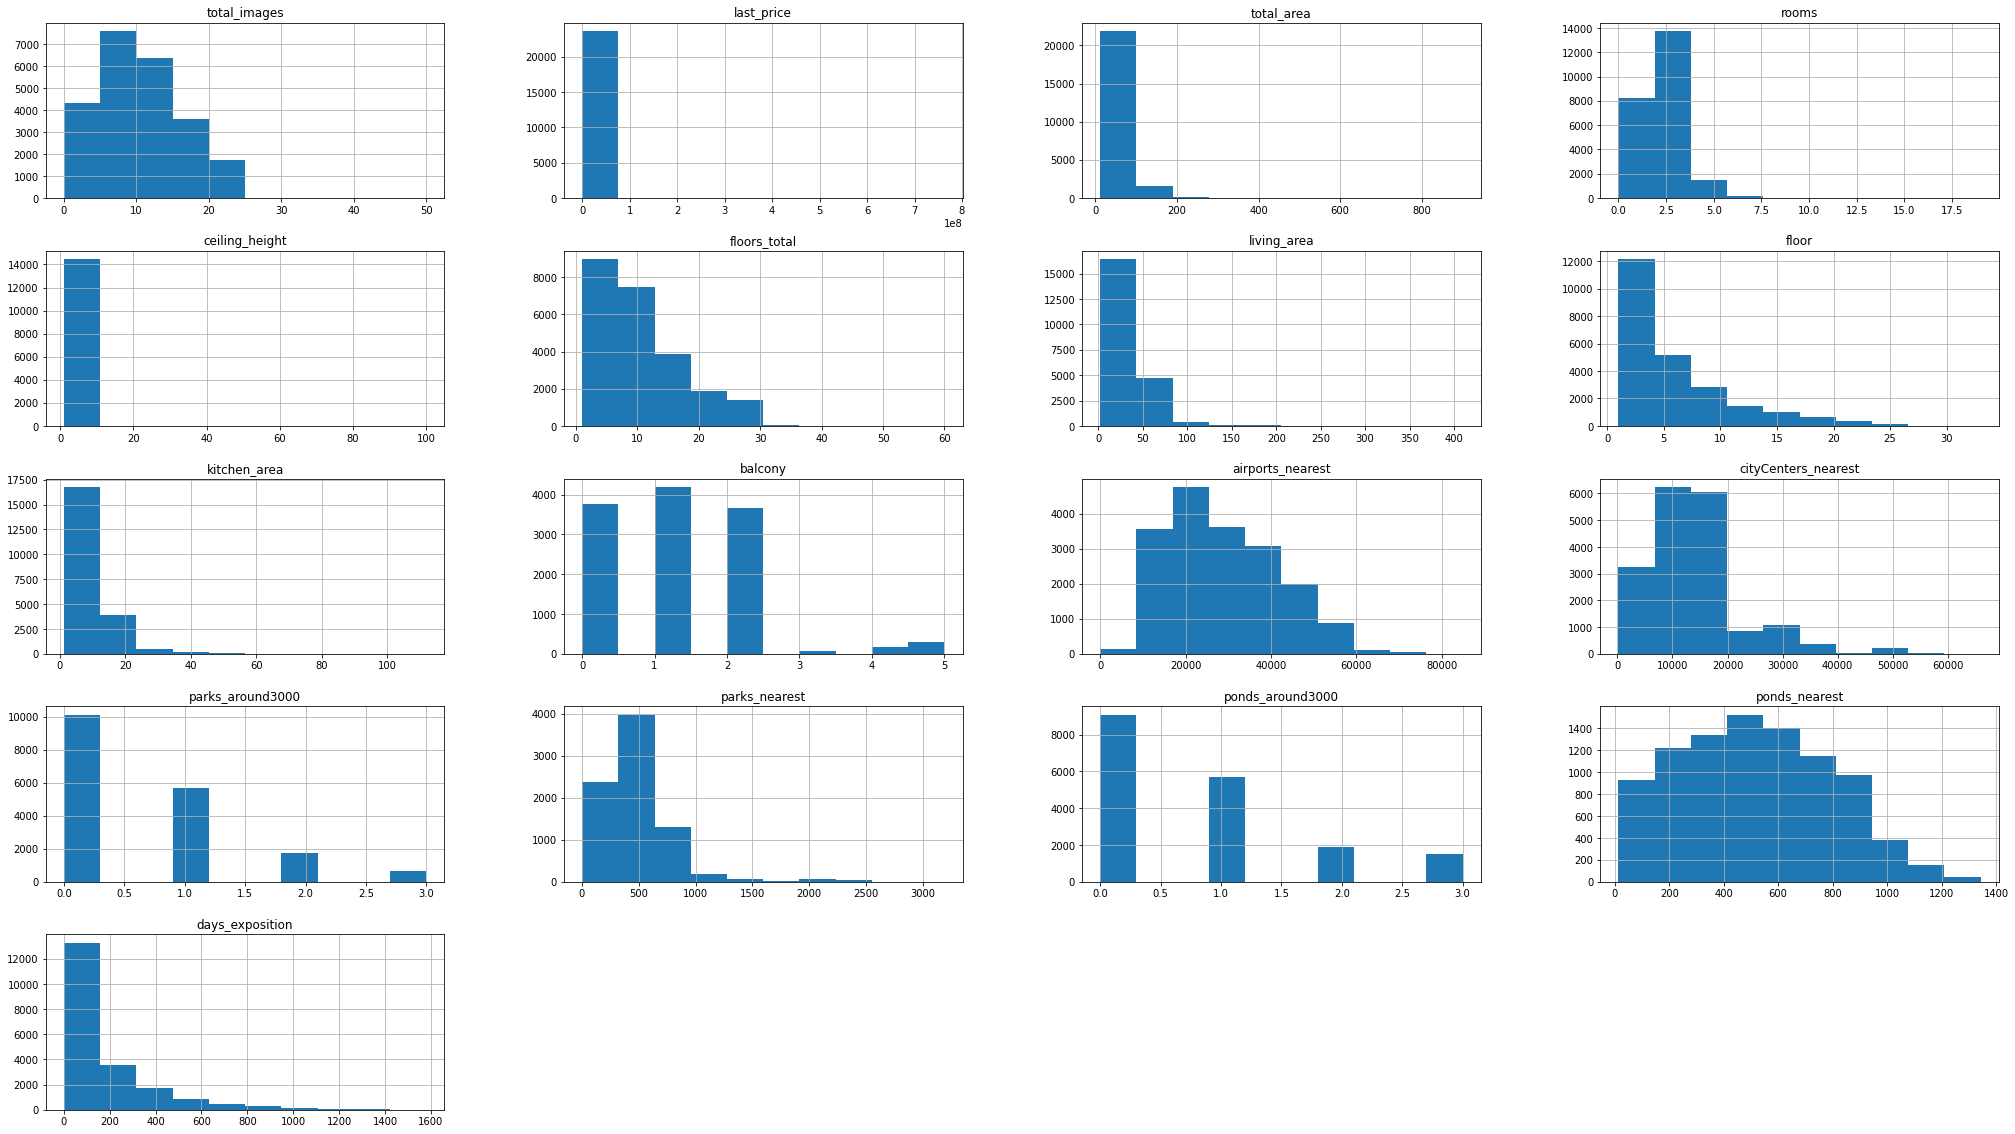

In [2]:
data.hist(figsize=(35,20))

на гистограммах видны пропуски в данных

### Выполните предобработку данных

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
data['balcony'] = data['balcony'].fillna(0) #заполнение пропусков нулем
mediana_ceiling_h = data['ceiling_height'].median() # объявление пременной с медианой высоты потолков 
data['ceiling_height'] = data['ceiling_height'].fillna(value=mediana_ceiling_h) # заполнение пропусков медианой
mean_area_l = data['living_area'].mean() #переменная со среднем жилой площади в км2
data['living_area'] = data['living_area'].fillna(value=mean_area_l) #заполнение пропусков перменной со среднем
mean_kitchen_a = data['kitchen_area'].mean() # переменная со среднем км2 территории кухни
data['kitchen_area'] = data['kitchen_area'].fillna(value=mean_kitchen_a) #заполнение пропусков перменной среднем кухни


In [5]:
#studio_false = data.loc[data['studio'] == False] #149 true
#openplan_false = data.loc[data['open_plan'] == False] # 67 true
data['is_apartment'] = data['is_apartment'].fillna(value=True) #заполняем пропуски в is_apartment значением True, так в studio и open_plan, положительных значений в сумме 216, означает что в датафрейме 149 недвижимости вида студия, и 67 со свободной планировкой


floors_total_m = data['floors_total'].median()
def new_floors_total(floor_total,floor,median):
    if floor_total > 0: # если кол-во этажей больше 0 
        floor_to_update = floor_total # вернуть без изменений
    elif floor > median: # если же этаж больше медианы 
            floor_to_update = floor # вернуть этаж
    else:
                floor_to_update = median # иначе новое кол-во этажей равно медиане
    return floor_to_update # вернуть обновленное колво этажей
data['floors_total'] = data.apply(lambda x:new_floors_total(x['floors_total'],x['floor'],floors_total_m),axis=1)
#применить к каждой строке лямбду функцию, к строке кол-во этажей и этаж, вконце медиана







data = data.dropna(subset=['locality_name']) #удаление строк без названия населенного пункта 


parks_ar3_m = data['parks_around3000'].mean() # поиск среднего
spb_median = data.loc[data['locality_name'] == 'Санкт-Петербург','cityCenters_nearest'].median() # среднее путь до центра объявлений из спб
data.loc[(data['locality_name'] == 'Санкт-Петербург') & (data['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = spb_median
# заполнение пропусков в cityCenters_nearest только для объявлений из спб 


были обнаружены и заполнены пропуски в датафрейме: кол-во балконов, жилая площадь, высота потолков, кухня, столбец с подтверждением того, что недвижимость это апартаменты, кол-во этажей в доме, расстояние до центра(только в городе Санкт Петербург), количество дней публикации объявление и продажи недвижимости.
удалены строки в которых нет названия города/поселка/села так как выводы будут некорректные.
airports_nearest было решено оставить как есть, так как можно допустить ошибку, так же и parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, airports_nearest.


пропуски в days_exposition было решено не трогать, судя по году они допущены случайно, если заполнить их то можно сделать некорректные выводы. 

In [6]:
# код ревьюера
import datetime as dt

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['first_day_year'] = data['first_day_exposition'].dt.year
data[data['days_exposition'].isnull()].pivot_table(columns = 'first_day_year', values = 'total_area', aggfunc = 'count')

first_day_year,2014,2015,2016,2017,2018,2019
total_area,18,70,67,271,958,1796


In [7]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')#смена формата
data['last_price'] = data['last_price'].astype(int)


был изменен тип данных в столбце дата публикации объявления, в верный формат datetime

In [8]:
data['locality_name'] = data['locality_name'].replace(['посёлок Мурино','поселок Мурино'], 'Мурино') # удаление неявных дубликатов
data['locality_name'] = data['locality_name'].replace(['посёлок Пансионат Зелёный Бор','поселок Пансионат Зелёный Бор'], 'посёлок Пансионат Зелёный Бор')
data['locality_name'] = data['locality_name'].replace(['поселок Рябово'], 'поселок городского типа Рябово')
data['locality_name'] = data['locality_name'].replace(['поселок Тельмана'], 'посёлок Тельмана')
data['locality_name'] = data['locality_name'].replace(['поселок Бугры'], 'посёлок Бугры')
data['locality_name'] = data['locality_name'].replace(['городской посёлок Мга'], 'посёлок городского типа Мга')


In [9]:
anomaly_borders = {} #счетчик аноималий
for i in ['total_area', 'rooms', 'ceiling_height', 'living_area', 'kitchen_area','last_price',]: # начало цикла, перебрать выбранные значения
    left_border = np.nanpercentile(data[i], 0.5) # низкие значения 0.5 %
    right_border = np.nanpercentile(data[i], 99.5) # высокие значения 0.5%
    anomaly_borders[i] = (left_border, right_border) # счетчик аномалий это значения низкого порога и высокого 

mask = np.ones(len(data), dtype=bool) # создание маски где сначала все значения True

for i in ['total_area', 'rooms', 'ceiling_height', 'living_area', 'kitchen_area','last_price',]:
    left_border, right_border = anomaly_borders[i] 
    mask &= (data[i] >= left_border) & (data[i] <= right_border) # обновление маски установление значеия False аномальным строкам

filt_data = data.loc[mask] # создание нового отфильтрованного датафрейма
filt_data.shape #(22731, 22)
shape #(23699, 22) отфильтрованно 968 строк

(23699, 22)

### Добавьте в таблицу новые столбцы

In [10]:
filt_data = filt_data.assign(price_square_meter=filt_data['last_price'] / filt_data['total_area']) #создание нового столбца с ценой за квадратный метр

day = {
    'Monday': 0, # словарь с днями недели
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}
filt_data['day_of_week'] = filt_data['first_day_exposition'].dt.day_name().map(day) # создаем новый столбец, применяем метод dt.day_name() для получения названий дней
# метод map применяется к результату чтобы отобразить названия дней недели на числа указанные в day 
filt_data['month'] = pd.DatetimeIndex(filt_data['first_day_exposition']).month #создание нового столбца с номером месяца 
filt_data['year'] = pd.DatetimeIndex(filt_data['first_day_exposition']).year #создание нового столбца с годом
def floor_type(row): # функция для создания столбца с типом этажа 
    total_floors = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == total_floors:
        return 'последний'
    else:
        return 'другой'
filt_data['floor_type'] = filt_data.apply(floor_type, axis=1) # применяем функцию к каждой строке по очереди   
filt_data['cityCenters_nearest_KM'] = filt_data['cityCenters_nearest'] / 1000
filt_data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,first_day_year,price_square_meter,day_of_week,month,year,floor_type,cityCenters_nearest_KM
0,20,13000000,108.00,2019-03-07,3,2.70,16.0,51.000000,8,True,...,2.0,755.0,NaN,2019,120370.370370,3,3,2019,другой,16.028
1,7,3350000,40.40,2018-12-04,1,2.65,11.0,18.600000,1,True,...,0.0,NaN,81.0,2018,82920.792079,1,12,2018,первый,18.603
2,10,5196000,56.00,2015-08-20,2,2.65,5.0,34.300000,4,True,...,2.0,574.0,558.0,2015,92785.714286,3,8,2015,другой,13.933
4,2,10000000,100.00,2018-06-19,2,3.03,14.0,32.000000,13,True,...,1.0,48.0,121.0,2018,100000.000000,1,6,2018,другой,8.098
5,10,2890000,30.40,2018-09-10,1,2.65,12.0,14.400000,5,True,...,NaN,NaN,55.0,2018,95065.789474,0,9,2018,другой,NaN
7,5,7915000,71.60,2019-04-18,2,2.65,24.0,34.457852,22,True,...,0.0,NaN,NaN,2019,110544.692737,3,4,2019,другой,11.634
8,20,2900000,33.16,2018-05-23,1,2.65,27.0,15.430000,26,True,...,NaN,NaN,189.0,2018,87454.764777,2,5,2018,другой,NaN
9,18,5400000,61.00,2017-02-26,3,2.50,9.0,43.600000,7,True,...,0.0,NaN,289.0,2017,88524.590164,6,2,2017,другой,15.008
10,5,5050000,39.60,2017-11-16,1,2.67,12.0,20.300000,3,True,...,2.0,553.0,137.0,2017,127525.252525,3,11,2017,другой,13.878
11,9,3300000,44.00,2018-08-27,2,2.65,5.0,31.000000,4,False,...,0.0,NaN,7.0,2018,75000.000000,0,8,2018,другой,51.677


были добавлены столбцы:
 – цена одного квадратного метра;
 – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
 – месяц публикации объявления;
 – год публикации объявления;
 – тип этажа квартиры (значения — «первый», «последний», «другой»);
 – расстояние до центра города в километрах.
 

### Проведите исследовательский анализ данных

среднее 58.317959614623206
максимальное 244.0
минимальное 23.5


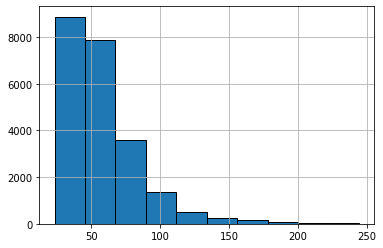

In [11]:
filt_data['total_area'].hist(edgecolor='black') # постройка гистограммы с черными краями
print('среднее',filt_data['total_area'].mean()) # рассчет среднего
print('максимальное',filt_data['total_area'].max()) # рассчет максимального 
print('минимальное',filt_data['total_area'].min()) # рассчет минимального 

общая площадь недвижимости, можно сказать что больше всего недвижимости с площадью меньше 50 квадратных метров, это видно по гистограмме и по среднему числу.
по минимальному значению понятно что в датафрейме присутствуют квартиры-студии, по максимальному можно сказать что есть недвижимость с открытой планировкой. разница между ними 225.2 что говорит о том что в датафрейме присутствуют различные типы недвижимости


среднее 33.442814506688265
максимальное 150.0
минимальное 11.47


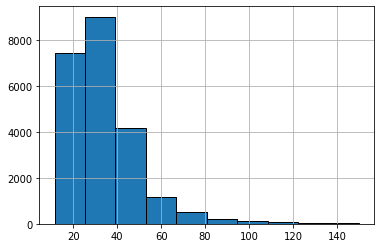

In [12]:
filt_data['living_area'].hist(edgecolor='black')
print('среднее',filt_data['living_area'].mean())
print('максимальное',filt_data['living_area'].max())
print('минимальное',filt_data['living_area'].min())

жилая площадь, можно более подробнее взглянуть на площадь недвижимости, все числа тут значительно меньше чем в общей площади, это обусловлено тем что жилая площадь и общая площадь недвижимости, это разные вещи. 
среднее 33, что может соответствовать обычной квартире.
максимальное 150, скорее всего это большие дома.
минимальное 11, это квартиры-студии.
по гистограмме такое же распределение как в общей площади.

среднее 10.28154181712005
максимальное 41.0
минимальное 5.0


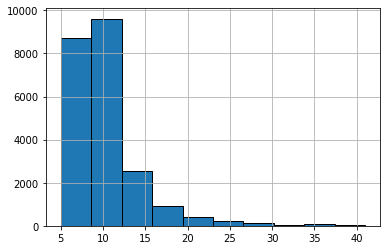

In [13]:
filt_data['kitchen_area'].hist(edgecolor='black')
print('среднее',filt_data['kitchen_area'].mean())
print('максимальное',filt_data['kitchen_area'].max())
print('минимальное',filt_data['kitchen_area'].min())

площадь кухни, распределение гистограммы такое же как в общей и жилой площади.
среднее говорит нам о том что в датафрейме распространены обычные квартиры.
максимальное говорит о присутствии большой недвижимости.
минимальное говорит о наличии квартир-студий.

среднее 5898051.906427346
максимальное 54000000
минимальное 800000


<AxesSubplot:>

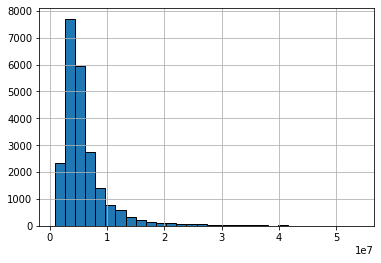

In [14]:
print('среднее',filt_data['last_price'].mean())
print('максимальное',filt_data['last_price'].max())
print('минимальное',filt_data['last_price'].min())
filt_data['last_price'].hist(bins=30, edgecolor='black')



цена при снятии объявлении с публикации, средняя цена около 6 миллионов рублей, что в принципе подходит под среднестатистическую квартиру. 
максимальное значение 54 миллиона, свидетельствует о наличии дома или больших квартир.
минимальное же подходит под квартиру-студию
гистограмма имеет распределение пауссона, на 30 интервалов, один интервал ровняется 1773333(53200000 / 30 = 1773333), начиная с 800000 заканчивая 54000000.
1 бин(800000 - 2573333)
2 бин(2573334 - 4346667)
3 бин(4346668 - 6120001)
по ней можно сделать вывод что 2573334 - 4346667 самая популярная цена в датафрейме, это неудивительно так-как было выяснено что "среднестатистических" квартир больше всего.

максимальное 6
минимальное 0


<AxesSubplot:>

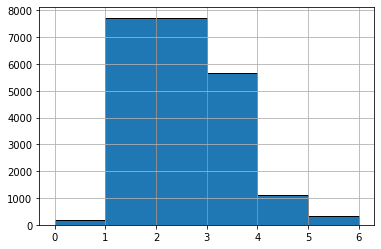

In [15]:

print('максимальное',filt_data['rooms'].max())
print('минимальное',filt_data['rooms'].min())
filt_data['rooms'].hist(bins=6, edgecolor='black')

больше всего недвижимости с 1-2 комнатами, что в принципе похоже на правду если судить по данным выше.
так же есть значения у 0, это квартиры-студии, комнат в них нет.
гистограмма имеет практически нормальное распределение.

среднее 2.6883581892569617
максимальное 3.95
минимальное 2.5


<AxesSubplot:>

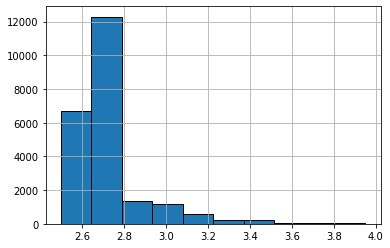

In [16]:
print('среднее',filt_data['ceiling_height'].mean())
print('максимальное',filt_data['ceiling_height'].max())
print('минимальное',filt_data['ceiling_height'].min())
filt_data['ceiling_height'].hist(edgecolor='black')

высота потолков, самая популярная высота около 2.8, что вполне нормально так-как выше уже было выяснено что "стандартные" квартир больше всего в таблице.
2.6 подходит квартирам-студиям, а 4 подходит под дорогую недвижимость.

<AxesSubplot:>

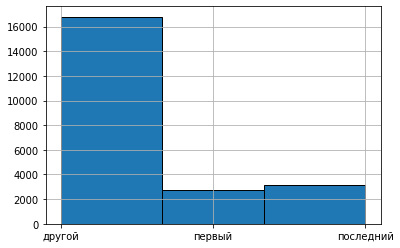

In [17]:

filt_data['floor_type'].hist(bins=3,edgecolor='black')

очевидно что другой этаж популярнее всех, но интересно то, что недвижимости с последним этажом чуть больше чем с первым.

среднее 10.777616470898773
максимальное 60.0
минимальное 1.0


<AxesSubplot:>

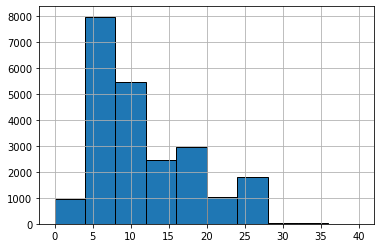

In [18]:
print('среднее',filt_data['floors_total'].mean())
print('максимальное',filt_data['floors_total'].max())
print('минимальное',filt_data['floors_total'].min())
filt_data['floors_total'].hist(edgecolor='black',range=(0,40))

по гистограмме видно что больше всего недвижимости в 5-этажных домах, что подтверждает вышесказанное, а именно - обычных квартир в датафрейме болььше всего. однако недвижимости с 25 этажами больше чем например с 20, это связано с тем что 20ти этажные дома менее популярны в строительстве нежели 25 этажные

среднее 14327.389952698468
максимальное 65968.0
минимальное 181.0


<AxesSubplot:>

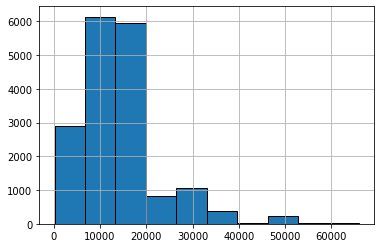

In [19]:
print('среднее',filt_data['cityCenters_nearest'].mean())
print('максимальное',filt_data['cityCenters_nearest'].max())
print('минимальное',filt_data['cityCenters_nearest'].min())
filt_data['cityCenters_nearest'].hist(edgecolor='black')

больше всего недвижимости находится в 10 километрах от центра, однако гистограмма неточная так-как имеются пропуски в данных, но для Санкт-Петербурга пропусков нет.

среднее 493.3750162654522
максимальное 3190.0
минимальное 1.0


<AxesSubplot:>

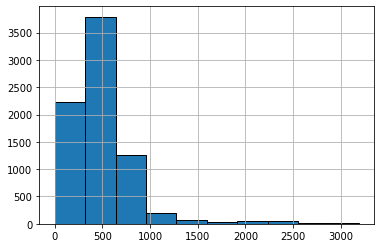

In [20]:
print('среднее',filt_data['parks_nearest'].mean())
print('максимальное',filt_data['parks_nearest'].max())
print('минимальное',filt_data['parks_nearest'].min())
filt_data['parks_nearest'].hist(edgecolor='black')

ближайший парк в 500 метрах у большинства недвижимости, однако эта гистограмма тоже несовсем достоверна из-за пропусков в данных, они не было заполненны так-как можно получить некорректные выводы.

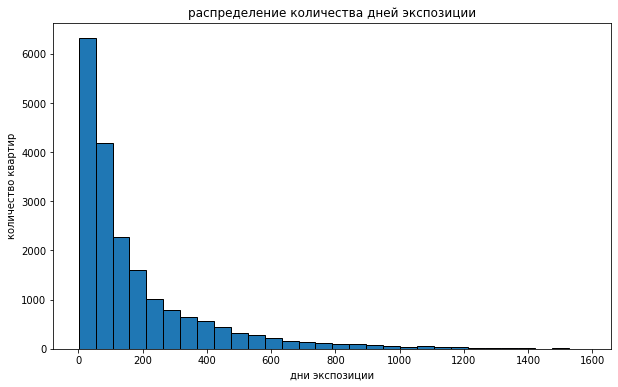

cреднее количество дней экспозиции: 179.79


count    19715.000000
mean       179.794826
std        218.767760
min          1.000000
25%         45.000000
50%         95.000000
75%        229.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [21]:
plt.figure(figsize=(10, 6)) # обозначение размера 10х6
plt.hist(filt_data['days_exposition'], bins=30, edgecolor='black') #  гистограмма на 30 корзин с черными краями
plt.title('распределение количества дней экспозиции') # название гистограммы
plt.xlabel('дни экспозиции') # надпись по иксу на гистограмме
plt.ylabel('количество квартир') # надпись по игреку на гистограмме
plt.show() # показать график 
mean_days = np.mean(filt_data['days_exposition']) # переменная со средним экспозиции 
median_days = np.median(filt_data['days_exposition']) # медиана экспозиции 

print(f"cреднее количество дней экспозиции: {mean_days:.2f}")
filt_data['days_exposition'].describe()

есть значительное количество квартир с очень короткой экспозицией (менее 50 дней)
обычно недвижимость продается за 5-6 месяцев.
половина недвижимости в датафрейме продается за 3 месяца.
быстрая продажа это продажа недвижимости за 50 дней.
необычно долгая продажа это продажа недвижимости за более чем 200 дней

продажа за 200 дней считается относительно быстрой продажей, а вот необычно долгая продажа все же считается выше 229 дней

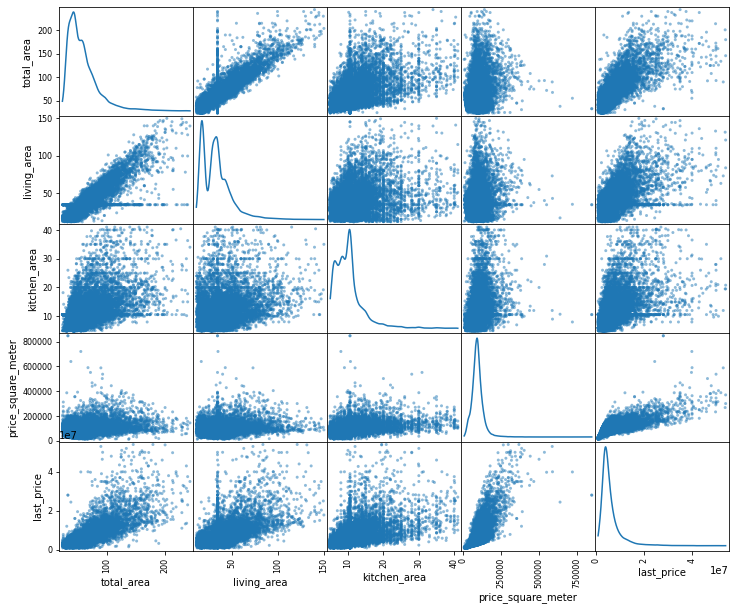

In [22]:

corr = filt_data.corr() # корреляция 
high_corr_cols = corr[abs(corr['last_price']) > 0.5].index.drop('last_price') # рассчет и наход высокой корреляции с ценой
high_corr_data = filt_data[list(high_corr_cols) + ['last_price']] # список имен столбцов с высокой корреляцией
pd.plotting.scatter_matrix(high_corr_data, figsize=(12, 10), diagonal='kde') # постройка матрицы рассеяния
plt.show() 


есть сильная положительная корреляция между ценой и общей площадью недвижимости(0.77), жилой площадью(0.63) и кухни(0.54) это означает что с увелечием этих площадей, цена так же будет возрастать
total_area 0.7654232980246072
living_area 0.6260186413627628
kitchen_area 0.5437866475199966

In [23]:
floor_type_pivot = pd.pivot_table(filt_data, index='floor_type', values='last_price', aggfunc='mean') # 0.46952224760988104
month_pivot = pd.pivot_table(filt_data, index='month', values='last_price', aggfunc='mean') # 0.0032032493151530708
day_pivot = pd.pivot_table(filt_data, index='day_of_week', values='last_price', aggfunc='mean') #-0.01822533702827188
years_pivot = pd.pivot_table(filt_data, index='year', values='last_price', aggfunc='mean') # -0.03790030069270992
#создание сводных таблиц с типом этажа, месяца, дня и года со средним последней цены 

корреляция между месяцем и последней ценой очень слабая но положительная(0.003), это означает что месяц имеет незначительное влияние на цену, возможно в некоторые месяцы идет небольшое повышение цены, но в целом связь слабая.
корреляция между днем и последней ценой слабая и отрицательная(-0.01), значит что день недели имеет очень слабое отрицательное влияние на цену, возможно в некоторые дни есть маленькое снижение цены.
корреляция между годом и последней ценой тоже слабая и отрицательная(-0.03), возможно в более поздние года цена ниже.
корреляция между типом этажа и ценой(0.47) средняя и положительная, можно сказать что тип этажа влияет на итоговую цену, судя по графику последний этаж либо же другой, выходит дороже чем первый. 

<AxesSubplot:xlabel='floor_type'>

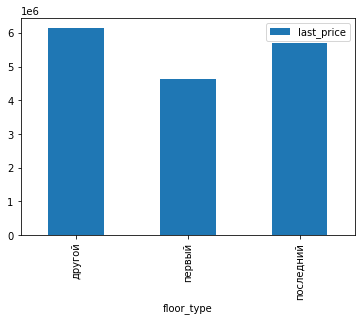

In [24]:
floor_type_pivot.plot(kind='bar') # постройка гистограммы

<AxesSubplot:xlabel='month'>

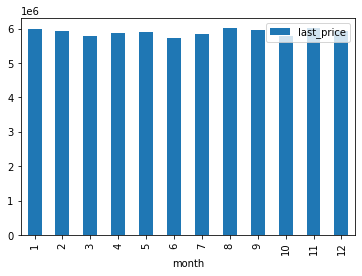

In [25]:
month_pivot.plot(kind='bar')

зависимость незначительная

<AxesSubplot:xlabel='day_of_week'>

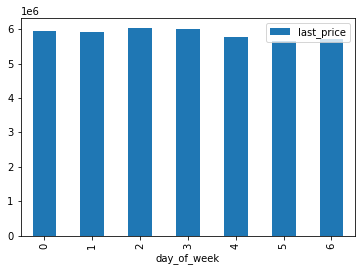

In [26]:
day_pivot.plot(kind='bar')

зависимость незначительная

<AxesSubplot:xlabel='year'>

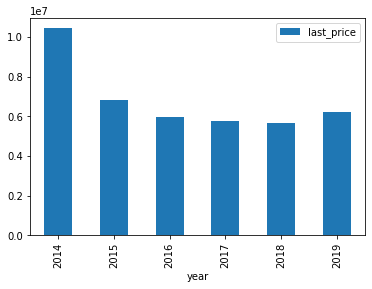

In [27]:
years_pivot.plot(kind='bar')

в 2014 году видно пик цены, однако потом он идет на спад, и в 2019 начинает расти.

In [28]:
localities = ['Санкт-Петербург', 'Мурино', 'посёлок Шушары','Всеволожск','Пушкин','Колпино','посёлок Парголово','Гатчина','деревня Кудрово','Выборг']

local = []
for locality in localities:
    mean_price = int(filt_data.loc[filt_data['locality_name'] == locality, 'price_square_meter'].mean())
    local.append({'город': locality, 'средняя цена за кв м': mean_price})

df = pd.DataFrame(local)
df.sort_values('средняя цена за кв м', ascending=False)

,город,средняя цена за кв м
0,Санкт-Петербург,111833
4,Пушкин,102922
8,деревня Кудрово,92287
6,посёлок Парголово,90217
1,Мурино,85445
2,посёлок Шушары,77914
5,Колпино,75258
7,Гатчина,68913
3,Всеволожск,68633
9,Выборг,58298


минимальная цена за квадратный метр в Выборге, а максимальная в поселке Парголово, топ 3 самых дорогих это Парголово,Санкт-Петербург и Пушкин, а топ 3 самых дешевых это Выборг, Всеволожск, Гатчина.

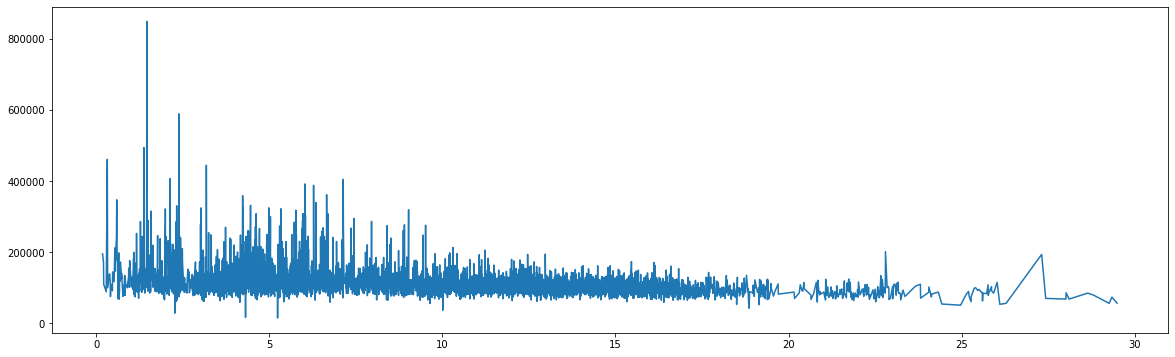

In [29]:
center_spb_data = filt_data.query('locality_name == "Санкт-Петербург"')
center_spb_data = center_spb_data.groupby('cityCenters_nearest_KM')['price_square_meter'].mean().reset_index()
center_spb_data = center_spb_data.sort_values('cityCenters_nearest_KM')
plt.figure(figsize=(20, 6))
plt.plot(center_spb_data['cityCenters_nearest_KM'], center_spb_data['price_square_meter'])

In [34]:
#код ревьюера
#здесь лучше округлить значения, чтобы на графике не было зашумленности

filt_data['cityCenters_nearest_KM'] = filt_data['cityCenters_nearest_KM'].round()
spb = filt_data.query('locality_name == "Санкт-Петербург"')
spb_hist = spb.groupby('cityCenters_nearest_KM')['price_square_meter'].mean().head(100).to_frame()
spb_hist['cityCenters_nearest_KM'] = spb_hist.index
spb_hist

,price_square_meter,cityCenters_nearest_KM
cityCenters_nearest_KM,,
0.0,197096.242249,0.0
1.0,144444.093178,1.0
2.0,136171.794084,2.0
3.0,118359.570965,3.0
4.0,127305.900692,4.0
5.0,135160.599926,5.0
6.0,141562.901771,6.0
7.0,141705.173820,7.0
8.0,123636.393210,8.0


<AxesSubplot:xlabel='cityCenters_nearest_KM'>

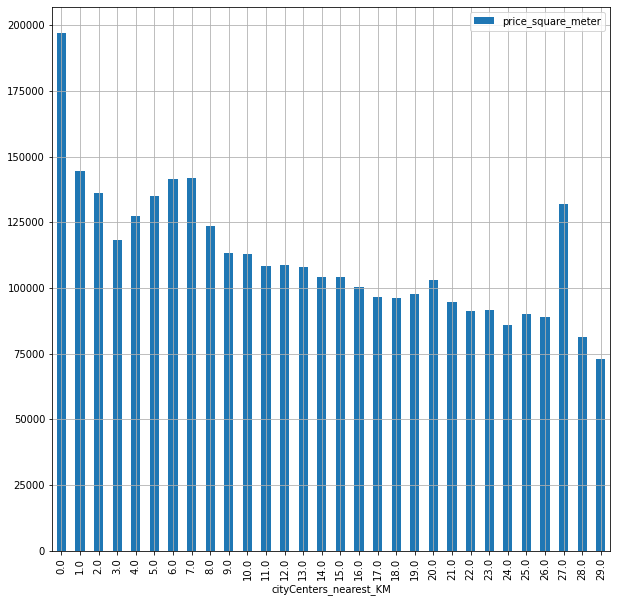

In [37]:
#код ревьюера
spb_hist.plot(kind = 'bar', x='cityCenters_nearest_KM', y='price_square_meter',figsize=(10,10), grid = True)

на графике видно что цена действительно зависит от места где находится недвижимость(рядом с центром или нет), так же можно заметить аномальные значения которые выбиваются из нормы, нужно проверить причины высокой цены, как нам известно на цену влияет площадь недвижимости, и немного этаж. 

In [31]:
filt_data['cityCenters_nearest_KM'] = filt_data['cityCenters_nearest_KM'].round() # округление расстояния до центра 
price_by_city_center_3 = (filt_data[(filt_data['locality_name'] == 'Санкт-Петербург') # спб и расстояние до центра
                                          & (filt_data['cityCenters_nearest_KM'] )]
                                          .pivot_table(index=['cityCenters_nearest_KM', 'floor_type'] # создание таблицы с расстоянием и типа этажа
                                                       , values=['price_square_meter', 'last_price', 'total_area'] # значения цены за кв метр последней цены и общей площади
                                                       , aggfunc='mean')).style.format({'last_price': '{:,.2f}'
                                                         , 'meter_price': '{:,.2f}'
                                                         , 'total_area': '{:,.2f}'}
                                                       )
                         
price_by_city_center_3

в сводной таблице как раз видно, что на расстоянии трех километров, недвижимость с этажем "другой" стоит дороже, так же общая площадь у нее выше, скорее всего поэтому есть высокая точка на графике.
на четырех километрах можно заметить тоже самое.
самую большую аномалию можно увидеть на расстоянии 27 километров, нужно взглянуть на эту строчку "поближе".

In [32]:
filt_data.query('total_area == 74 and cityCenters_nearest_KM == 27') # строка с общей площадью 74 и расстоянием 27 км

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,first_day_year,price_square_meter,day_of_week,month,year,floor_type,cityCenters_nearest_KM
748,13,14350000,74.0,2017-11-28,2,3.13,5.0,30.0,3,True,...,0.0,NaN,128.0,2017,193918.918919,1,11,2017,другой,27.0


судя по высоте потолка, аппартаменты элитного класса, так же на это намекает то что ее продали за 128 дней, то есть жилье востребованное.

### Напишите общий вывод

была проделана большая работа над данными, исправлены пропущенные значения там где это было целесообразно делать, на среднее число, либо же на 0(кол-во балконов) или буллево значение(True) в аппартаментах, в целом эти два значения на итоговый результат никак не повлияли. были удалены строки без названия населенного пункта, т.к. анализ по ним было бы некорректно проводить.
были изменены типы данных на datetime и int, так-же устранены неявные дубликаты.
найдены и отфильтрованны аномальные значения 0.5% высоких и 0.5% низких, в общей площади, кухне, жилой площади, комнатах, высоте потолков, последней цены создан новый отфильтрованный датафрейм.
добавлены новые столбцы в датафрейм, такие как: цена одного квадратного метра, день публикации объявления (0 - понедельник, 1 - вторник и т. д.), месяц публикации объявления, год публикации объявления, тип этажа квартиры (значения — «первый», «последний», «другой»), расстояние до центра города в километрах.
проведен исследовательский анализ данных было выяснено что больше всего недвижимости с площадью меньше 50 квадратных метров при этом минимальное значение 23.5 а максимальное 244, больше всего недвижимости это "стандартные" квартиры, самая популярная цена у недвижимости это (2573334 - 4346667), что опять же подтверждает то, что обычных квартир больше всего, при этом максимальное значение 54 миллиона, минимальное же 800 тысяч. больше всего квартир оказалось с 1-2 комнатами, так же присутствуют квартиры со значением 0, это подходит под квартиру-студию, вариация комнат от 0 до 6.
высота потолков варируется от 2.6 до 4 метров, самая популярная из них это 2.8 
самый популярный этаж - другой, потом идет последний, и самый не популярный это первый этаж.
однако больше всего 5ти этажных домов в датафрейме, варируется от 1 до 60 этажа,говорит о том, что есть недвижимость в небоскребах.
больше всего недвижимости находится в радиусе 10 км от центра, самый высокий показатель это 65 км, а низкий 180 метров, однако данные не точные, так как имеются пропуски.
ближайший парк находится в 500 метрах у большинства недвижимости, но они тоже не точные по той же причине.
недвижимость продается за 5-6 месяцев. половина недвижимости в датафрейме продается за 3 месяца. быстрая продажа это продажа недвижимости за 50 дней. необычно долгая продажа это продажа недвижимости за более чем 200 дней.
выяснено что есть взаимосвязь между общей площадью, жилой площадью, кухней и ценой, само собой больше всего на цену влияет общая площадь(0.77), отсюда можно понять что цена вырастит если вырастит общая площадь что само по себе логично.
корреляция между месяцем и ценой незначительная, тоже самое можно сказать про день и год, разве что цена повышается с каждым последующем годом. 
а вот корреляция между типом этажа и ценой средняя и положительная, то есть можно сделать вывод что на цену влияет тип этажа, если рассматривать график, можно понять что последний и другой этажи, дороже чем первый.
выявлены топ 10 населенных пунктов по количеству объявлений и рассчитаны цены за квадратный метр в них. 
минимальная цена за квадратный метр в Выборге, а максимальная в поселке Парголово, топ 3 самых дорогих это Парголово,Санкт-Петербург и Пушкин, а топ 3 самых дешевых это Выборг, Всеволожск, Гатчина.
проведен анализ, целью которого было выяснить, влияет ли расстояние до центра на цену в городе СПб.
выяснено что да влияет, но были обнаружены аномальные значения, их было немного.
так как нам известно что на цену влияет общая площадь и тип этажа, было решено проверить именно их, и да действительно у типа этажа другой или последний цена выше, и площадь тоже выше, как раз эти точки и были на графике "аномальными".
идеальная недвижимость исходя из данных должна быть площадью 50-70 квадратных метров, на расстоянии 1 км до центра и на любом этаже кроме первого.
по поводу пропусков, в большинстве случаев это явно человеческий фактор, в строке 'its_apartment" было абсолютное большинство пропусков(~20k) так же видно что сначала они заполнялись, а потом видимо про эту строчку забыли, тоже самое могу сказать про общую площадь, кухню и жилую(0 там просто не может быть логически). однако есть строки где пропуски обусловлены скорее тем, что например нет рядом парка или недвижимость находится в селе/деревне и как такового центра у них нет. так-как достоверно узнать расстояние до аэропорта, парка, центра и водоема невозможно и можно допустить ошибку, из за чего выводы будут некорректные, было принято решение оставить эти столбцы нетронутыми.

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [x]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [x]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [x]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [x]  В конце проекта сделан общий вывод.